Quick Start
- https://langchain-ai.github.io/langgraph/tutorials/introduction/

## Part 1: Build a Basic Chatbot¶

In [3]:
%%capture --no-stderr
%pip install -U langgraph langsmith

# Used for this tutorial; not a requirement for LangGraph
%pip install -U langchain_anthropic

In [4]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

In [5]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

In [6]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [7]:
from langchain_anthropic import ChatAnthropic

llm = ChatAnthropic(model="claude-3-haiku-20240307")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [8]:
graph_builder.add_edge(START, "chatbot")

In [9]:
graph_builder.add_edge("chatbot", END)

In [10]:
graph = graph_builder.compile()

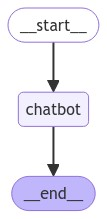

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [10]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: Hello! How can I assist you today?
Assistant: I don't actually have any direct information about the current weather. As an AI assistant without direct access to weather data, I don't have a way to report on the specific weather conditions. The weather can vary greatly depending on location and time of day. Without more details about your location, I can't provide any specific information about the current weather where you are. I'd suggest checking an online weather report or app to get the latest details on the weather in your area.
Assistant: Here is a basic recipe and instructions for making homemade pizza:

Ingredients:
- 1 lb pizza dough (you can buy pre-made or make your own)
- 1 cup pizza sauce
- 2-3 cups shredded mozzarella cheese
- Desired toppings (such as pepperoni, mushrooms, onions, etc.)

Instructions:

1. Preheat your oven to 450°F (230°C).

2. Prepare the pizza dough. If using pre-made dough, let it come to room temperature. If making your own, follow the re

## Part 2: Enhancing the Chatbot with Tools

In [12]:
%%capture --no-stderr
%pip install -U tavily-python
%pip install -U langchain_community

In [13]:
_set_env("TAVILY_API_KEY")

In [14]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'Nodes¶ In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id). Similar to NetworkX, you add these nodes to a graph using the add_node method:'},
 {'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
  'content': 'Each node in a LangGraph graph has the ability to access, read, and write to the state. When a node modifies the state, it effectively broadcasts this information to all other nodes within the ...'}]

In [15]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatAnthropic(model="claude-3-haiku-20240307")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [16]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [17]:
from typing import Literal


def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

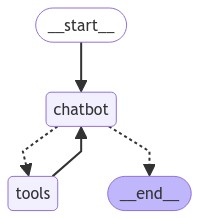

In [18]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [19]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

Assistant: [{'id': 'toolu_01KqzFk4ttmPXZhid2pZh1Fz', 'input': {'query': 'good places to travel with kids'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Assistant: [{"url": "https://fullsuitcase.com/best-family-travel-destinations/", "content": "3. Bali, Indonesia. Recommended by Eric from Travel Babbo. Bali has become one of our favorite family travel destinations the past couple of years. There's a perfect mix of beaches and culture, and there's always something to do, from attending festivals (which seem to take place all the time) to visiting water parks to hiking through rice fields."}, {"url": "https://familyvacationist.com/bucket-list-family-vacation-destinations-around-the-world/", "content": "Add in a two-bedroom beach villa with a private garden, an under-the-stars outdoor shower, and a private turquoise pool, and you have the makings of the most magical and memorable family vacation on the planet. 3. Paris and Normandy, France. A trip to Paris should be on ever

## Part 3: Adding Memory to the Chatbot

In [20]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [21]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [22]:
graph = graph_builder.compile(checkpointer=memory)

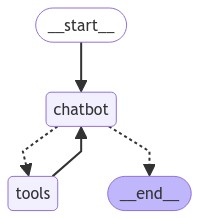

In [23]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [24]:
config = {"configurable": {"thread_id": "1"}}

In [25]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

It's nice to meet you, Will! I'm an AI assistant created by Anthropic. I'm here to help with any questions or tasks you may have. Please let me know how I can assist you today.


In [26]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name is Will. It's a pleasure to meet you!


In [27]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

It seems you have not explicitly told me your name yet. Could you please provide your name so I can remember it?


In [28]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', id='772d7d15-f7f0-4c8c-b118-b464afdb3ff0'), AIMessage(content="It's nice to meet you, Will! I'm an AI assistant created by Anthropic. I'm here to help with any questions or tasks you may have. Please let me know how I can assist you today.", response_metadata={'id': 'msg_01VjC6VitFNhN3aFPYpLjy2a', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 375, 'output_tokens': 48}}, id='run-421d17a1-dc2c-43fa-848b-c7bab1ced1c7-0', usage_metadata={'input_tokens': 375, 'output_tokens': 48, 'total_tokens': 423}), HumanMessage(content='Remember my name?', id='72fe238e-84fe-45d7-bafc-a234b8b07c4d'), AIMessage(content="Yes, I remember your name is Will. It's a pleasure to meet you!", response_metadata={'id': 'msg_01VQ3PojTrD4wd546dxg5ZVZ', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 430, 

In [29]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()

## Part 4: Human-in-the-loop

In [30]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

memory = MemorySaver()


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [31]:
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ tools, if desired.
    # interrupt_after=["tools"]
)

In [32]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================

[{'id': 'toolu_012BgqH7qpFDQpR43XKyREXN', 'input': {'query': 'langGraph'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_012BgqH7qpFDQpR43XKyREXN)
 Call ID: toolu_012BgqH7qpFDQpR43XKyREXN
  Args:
    query: langGraph


In [33]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [34]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'langGraph'},
  'id': 'toolu_012BgqH7qpFDQpR43XKyREXN',
  'type': 'tool_call'}]

In [35]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'id': 'toolu_012BgqH7qpFDQpR43XKyREXN', 'input': {'query': 'langGraph'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_012BgqH7qpFDQpR43XKyREXN)
 Call ID: toolu_012BgqH7qpFDQpR43XKyREXN
  Args:
    query: langGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://github.com/langchain-ai/langgraph", "content": "LangGraph is a framework for creating stateful, multi-actor applications with LLMs, using cycles, controllability, and persistence. It integrates with LangChain and LangSmith, and supports human-in-the-loop and streaming features."}, {"url": "https://www.langchain.com/langgraph", "content": "LangGraph is a framework for building stateful, multi-actor agents with LLMs that can handle complex scenarios and collaborate with humans. Learn how to use LangGraph

## Part 5: Manually Updating the State

In [38]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt **after** actions, if desired.
    # interrupt_after=["tools"]
)

user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [39]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================

[{'text': "Okay, let's look into LangGraph in more detail. Here is a search for information on LangGraph:", 'type': 'text'}, {'id': 'toolu_01HMqJtK4UALHnqZAYhEvLWm', 'input': {'query': 'LangGraph'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01HMqJtK4UALHnqZAYhEvLWm)
 Call ID: toolu_01HMqJtK4UALHnqZAYhEvLWm
  Args:
    query: LangGraph


In [40]:
from langchain_core.messages import AIMessage

answer = (
    "LangGraph is a library for building stateful, multi-actor applications with LLMs."
)
new_messages = [
    # The LLM API expects some ToolMessage to match its tool call. We'll satisfy that here.
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    # And then directly "put words in the LLM's mouth" by populating its response.
    AIMessage(content=answer),
]

new_messages[-1].pretty_print()
graph.update_state(
    # Which state to update
    config,
    # The updated values to provide. The messages in our `State` are "append-only", meaning this will be appended
    # to the existing state. We will review how to update existing messages in the next section!
    {"messages": new_messages},
)

print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])

================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


Last 2 messages;
[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='3df6476c-15de-4639-bf97-af2875481912', tool_call_id='toolu_01HMqJtK4UALHnqZAYhEvLWm'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='56e9d209-dc0e-45f0-840a-71a6820d3e15')]


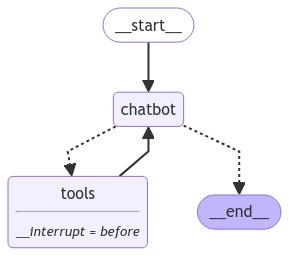

In [41]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [42]:
snapshot = graph.get_state(config)
print(snapshot.values["messages"][-3:])
print(snapshot.next)

[AIMessage(content=[{'text': "Okay, let's look into LangGraph in more detail. Here is a search for information on LangGraph:", 'type': 'text'}, {'id': 'toolu_01HMqJtK4UALHnqZAYhEvLWm', 'input': {'query': 'LangGraph'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], response_metadata={'id': 'msg_01PsLy8trm16KduYNjJaGPjD', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 384, 'output_tokens': 85}}, id='run-7f9e41f3-7f12-4dda-86bc-d8d548138461-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': 'toolu_01HMqJtK4UALHnqZAYhEvLWm', 'type': 'tool_call'}], usage_metadata={'input_tokens': 384, 'output_tokens': 85, 'total_tokens': 469}), ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='3df6476c-15de-4639-bf97-af2875481912', tool_call_id='toolu_01HMqJtK4UALHnqZAYhEvLWm'), AIMessage(content='LangGraph is a library for buildin

In [43]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "2"}}  # we'll use thread_id = 2 here
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================

[{'text': "Okay, let's look up some information on LangGraph for you:", 'type': 'text'}, {'id': 'toolu_0137rB6zWMAXfyFPSXAVv5NU', 'input': {'query': 'LangGraph'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_0137rB6zWMAXfyFPSXAVv5NU)
 Call ID: toolu_0137rB6zWMAXfyFPSXAVv5NU
  Args:
    query: LangGraph


In [44]:
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
print("Original")
print("Message ID", existing_message.id)
print(existing_message.tool_calls[0])
new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "LangGraph human-in-the-loop workflow"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state rather than APPEND this messages
    id=existing_message.id,
)

print("Updated")
print(new_message.tool_calls[0])
print("Message ID", new_message.id)
graph.update_state(config, {"messages": [new_message]})

print("\n\nTool calls")
graph.get_state(config).values["messages"][-1].tool_calls

Original
Message ID run-5f150609-0121-4185-bbc0-ddda703dc407-0
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': 'toolu_0137rB6zWMAXfyFPSXAVv5NU', 'type': 'tool_call'}
Updated
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph human-in-the-loop workflow'}, 'id': 'toolu_0137rB6zWMAXfyFPSXAVv5NU', 'type': 'tool_call'}
Message ID run-5f150609-0121-4185-bbc0-ddda703dc407-0


Tool calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph human-in-the-loop workflow'},
  'id': 'toolu_0137rB6zWMAXfyFPSXAVv5NU',
  'type': 'tool_call'}]

In [45]:
events = graph.stream(
    {
        "messages": (
            "user",
            "Remember what I'm learning about?",
        )
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember what I'm learning about?


BadRequestError: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.2: Did not find 1 `tool_result` block(s) at the beginning of this message. Messages following `tool_use` blocks must begin with a matching number of `tool_result` blocks.'}}

## Part 6: Customizing State

In [46]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool

In [47]:
from langchain_core.pydantic_v1 import BaseModel


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str

In [48]:
tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

In [49]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))

In [50]:
from langchain_core.messages import AIMessage, ToolMessage


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)

In [51]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)

In [52]:
# The rest is the same
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here instead.
    interrupt_before=["human"],
)

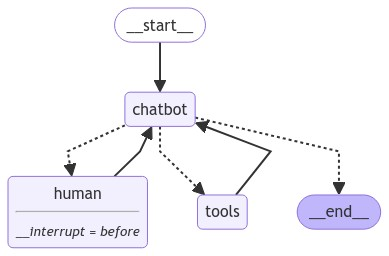

In [53]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [54]:
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================

[{'id': 'toolu_014XWDMwqVo51AjoNuc2tBkW', 'input': {'request': 'I need some expert guidance for building this AI agent.'}, 'name': 'RequestAssistance', 'type': 'tool_use'}]
Tool Calls:
  RequestAssistance (toolu_014XWDMwqVo51AjoNuc2tBkW)
 Call ID: toolu_014XWDMwqVo51AjoNuc2tBkW
  Args:
    request: I need some expert guidance for building this AI agent.


In [55]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

In [56]:
ai_message = snapshot.values["messages"][-1]
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)
tool_message = create_response(human_response, ai_message)
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef69a08-901e-6898-8002-aea55f708040'}}

In [57]:
graph.get_state(config).values["messages"]

[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', id='24999ddd-b6ad-423f-ba1a-83e3e5ee9f99'),
 AIMessage(content=[{'id': 'toolu_014XWDMwqVo51AjoNuc2tBkW', 'input': {'request': 'I need some expert guidance for building this AI agent.'}, 'name': 'RequestAssistance', 'type': 'tool_use'}], response_metadata={'id': 'msg_01PHaUjjLWgdy1UkLu5MxRD2', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 486, 'output_tokens': 63}}, id='run-8ad50b6e-a7e2-46c0-b3a6-a325d9ff832c-0', tool_calls=[{'name': 'RequestAssistance', 'args': {'request': 'I need some expert guidance for building this AI agent.'}, 'id': 'toolu_014XWDMwqVo51AjoNuc2tBkW', 'type': 'tool_call'}], usage_metadata={'input_tokens': 486, 'output_tokens': 63, 'total_tokens': 549}),
 ToolMessage(content="We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more re

In [58]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

The experts have been notified of your request for guidance on building an AI agent. They've suggested checking out LangGraph, which they say is a more reliable and extensible solution compared to simpler autonomous agents. Let me know if you have any other questions and I'll be happy to relay them to the experts.


## Part 7: Time Travel


In [59]:
from typing import Annotated, Literal

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.pydantic_v1 import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)


def select_next_node(state: State) -> Literal["human", "tools", "__end__"]:
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

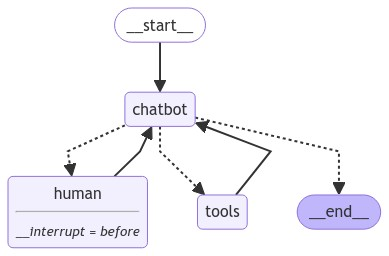

In [60]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [61]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            ("user", "I'm learning LangGraph. Could you do some research on it for me?")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================

[{'text': 'Okay, let me do some research on LangGraph for you. Here is what I found:', 'type': 'text'}, {'id': 'toolu_01HE8ZDriitcK3W2MEAXr7vG', 'input': {'query': 'LangGraph'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01HE8ZDriitcK3W2MEAXr7vG)
 Call ID: toolu_01HE8ZDriitcK3W2MEAXr7vG
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.langchain.com/langgraph", "content": "LangGraph is a framework for building stateful, multi-actor agents with LLMs that can handle complex scenarios and collaborate with humans. Learn how to use LangGraph with Python or JavaScript, and deploy your agent

In [62]:
events = graph.stream(
    {
        "messages": [
            ("user", "Ya that's helpful. Maybe I'll build an autonomous agent with it!")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

[{'text': "That's great that you're interested in building an autonomous agent using LangGraph! That sounds like a really interesting project. Here are a few additional thoughts and suggestions as you explore using LangGraph for that:", 'type': 'text'}, {'id': 'toolu_018bcnnf8LvPXSUL3GhDQ6XM', 'input': {'query': 'building autonomous agents with LangGraph'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_018bcnnf8LvPXSUL3GhDQ6XM)
 Call ID: toolu_018bcnnf8LvPXSUL3GhDQ6XM
  Args:
    query: building autonomous agents with LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.oreilly.com/library/view/building-auton

In [63]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  8 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  7 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
-----------------------------------------

In [64]:
print(to_replay.next)
print(to_replay.config)

('tools',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef69a11-41f5-644e-8006-a4f8a7abe9d4'}}


In [65]:
# The `thread_ts` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': "That's great that you're interested in building an autonomous agent using LangGraph! That sounds like a really interesting project. Here are a few additional thoughts and suggestions as you explore using LangGraph for that:", 'type': 'text'}, {'id': 'toolu_018bcnnf8LvPXSUL3GhDQ6XM', 'input': {'query': 'building autonomous agents with LangGraph'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_018bcnnf8LvPXSUL3GhDQ6XM)
 Call ID: toolu_018bcnnf8LvPXSUL3GhDQ6XM
  Args:
    query: building autonomous agents with LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.oreilly.com/library/view/building-autonomous-ai/9781836643159/", "content": "Title: Building Autonomous AI Agents with LangGraph. Author (s): Paulo Dichone. Release date: August 2024. Pu